# IP Address Anomaly Detection & Carrier Data Cleaning  

## 1. Data Loading and Initial Inspection  
- Loaded the primary dataset from an Excel file containing normalized network data.  
- Checked for missing values in the dataset.  

## 2. Missing Carrier Information Detection  
- Created a flag `missing_carrier` to identify rows where the `carrier` field is missing.  
- Stored the flagged data in a new DataFrame (`dfMissingFlags`).  

## 3. Identifying Impossible IP Addresses  
- Loaded a separate dataset containing IP addresses and their validity status.  
- Dropped unnecessary columns (`message`) from the IP dataset.  
- Identified fake or impossible IP addresses where `status == 'fail'`.  
- Mapped these IPs and flagged their presence in the main dataset using the `impossible_ips` column.  

## 4. Merging IP Metadata and Geolocation Data  
- Renamed IP dataset columns for clarity (`country → ip_country`, `lat → ip_lat`, `lon → ip_lon`, `query → ipAddress`).  
- Filled missing values in the IP dataset with default values (`0` or `"Unknown"` for failed IP lookups).  
- Merged the enriched IP metadata with the main dataset using `ipAddress`.  

## 5. Country Code Mismatch Detection  
- Created a mapping for country names to standardized country codes (`pak` for Pakistan, `hkg` for Hong Kong, etc.).  
- Derived a new column `country_code_ip` using this mapping on the `ip_country` field.  
- Compared `country_code_ip` with `device_country_code` to flag mismatches (`country_code_mismatch`).  

## 6. Summary Statistics and Export  
- Counted and printed the number of flagged records for:  
  - Missing carrier data  
  - Impossible IP addresses  
  - Country code mismatches  
- Exported the flagged records (`missing_carrier`, `impossible_ips`, `country_code_mismatch`) to a CSV file for further analysis.  

---

### Key Insights  
- Detecting missing carrier data helps in assessing data completeness and potential errors in the dataset.  
- Identifying impossible IPs ensures that fake or spoofed addresses do not impact network security analysis.  
- Flagging country mismatches between IP-based geolocation and device settings can help detect VPN/proxy usage or fraud attempts.  
- Further analysis could involve anomaly detection techniques or integrating external threat intelligence sources for enhanced accuracy.  


In [3]:
import pandas as pd

In [4]:
df = pd.read_excel(r"C:\Users\Tanmay\V-Patrol\work\CombinedCountryData_2.0-IPv4_Cleaned.xlsx",sheet_name="normalized_file123")

In [5]:
df.isna().sum()

reqTimeConverted          0
deviceIfa                 0
os                        0
osv                       0
normalized_osv            0
ipAddress                 0
carrier                4039
connectionType            0
device_vendor           216
device_model              0
device_height             0
device_width              0
deviceType                0
location_type             0
latitude                  0
longitude                 0
appBundle                 0
device_country_code       0
ua                        0
dtype: int64

In [6]:
dfMissingFlags = pd.DataFrame()
dfMissingFlags["missing_carrier"] = df["carrier"].isna()
dfMissingFlags.shape

(121585, 1)

In [8]:
# Load IP data from a CSV file created using https://ip-api.com/
ipData = pd.read_csv(r"C:\Users\Tanmay\V-Patrol\work\uniqueIPs.csv")

# Drop the unnecessary 'message' column
ipData.drop(columns=["message"], inplace=True)

# Identify fake or impossible IP addresses where status is 'fail'
fakeIps = ipData[ipData["status"] == 'fail']

# Convert the list of fake IP addresses to a list
ipsToRemove = fakeIps['query'].to_list()

# Add the 'ipAddress' column to dfMissingFlags from the main dataframe
dfMissingFlags["ipAddress"] = df["ipAddress"]

# Flag the presence of impossible IPs in the main dataset
dfMissingFlags["impossible_ips"] = dfMissingFlags["ipAddress"].isin(ipsToRemove)

# Output the shape of the dfMissingFlags DataFrame
dfMissingFlags.shape

(121585, 3)

In [9]:
print(dfMissingFlags[dfMissingFlags["missing_carrier"]==True].shape)
print(dfMissingFlags[dfMissingFlags["impossible_ips"]==True].shape)

(4039, 3)
(4, 3)


In [10]:
IPsData = ipData.rename(columns={"country": "ip_country", "lat": "ip_lat", "lon": "ip_lon", "query": "ipAddress"})
IPsData.fillna(0,inplace=True)

In [11]:
IPsData.iloc[IPsData["status"]=="fail",1] = "Unknown"

In [12]:
IPsData.drop("status",axis=1,inplace=True)

In [13]:
df1_updated = df.merge(IPsData, on="ipAddress", how="left")
country_mapping = {
    "Pakistan":"pak",
    "Hong Kong":"hkg",
    "India":"ind",
    "Bangladesh":"bgd",
    "Nepal":"npl"
}

df1_updated["country_code_ip"] = df1_updated["ip_country"].apply(lambda x: country_mapping.get(x, "Unknown"))

In [24]:
df1_updated["country_code_misatch"] = df1_updated["country_code_ip"] != df1_updated["device_country_code"]

In [14]:
dfMissingFlags["country_code_misatch"] = df1_updated["country_code_ip"] != df1_updated["device_country_code"]

In [15]:
dfTocsv = dfMissingFlags[["missing_carrier","impossible_ips","country_code_misatch"]]

In [16]:
# dfTocsv.to_csv(r"C:\Users\tanmay\V-Patrol\featureEngineering\feature_4_5_6.csv")

# Visualization and Insights

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from IPython.display import display

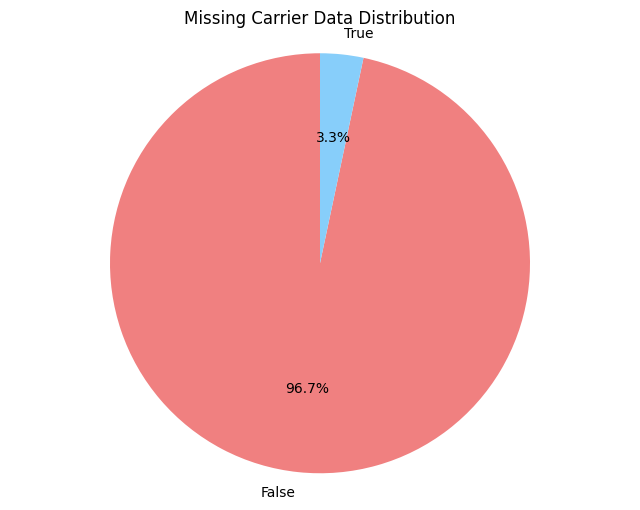

In [17]:
# Count the missing and non-missing carrier data
missing_carrier_counts = dfMissingFlags["missing_carrier"].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(missing_carrier_counts, labels=missing_carrier_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Missing Carrier Data Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### **Insights from the Pie Chart on Missing Carrier Information**  

**Very Few Devices Have Missing Carrier Information**  
   - **Only 3.3% of devices lack carrier details.**  
   - This could be due to:  
     - **Anonymized or spoofed devices** (e.g., bots, VPN users, or modified firmware).  

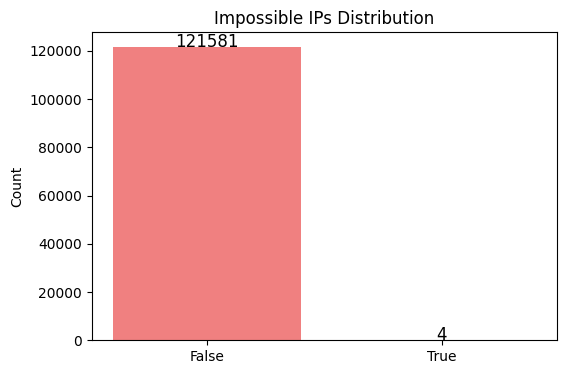

In [21]:
# Count values
impossible_ips_counts = dfMissingFlags["impossible_ips"].value_counts()

# Convert index to string labels
labels = ['False', 'True']

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, impossible_ips_counts, color=['lightcoral', 'lightskyblue'])
plt.ylabel("Count")
plt.title("Impossible IPs Distribution")

# Annotate values
for i, v in enumerate(impossible_ips_counts):
    plt.text(i, v + 100, str(v), ha='center', fontsize=12)

plt.show()


## Analysis of impossible IPs:

### **Impossible IP Addresses**    
  - **Technical Context**:  
    - `0.0.0.0` is a non-routable placeholder IP (often used for misconfigured systems or DHCP failures).  
    - `253.190.255.137` and `233.139.4.167` fall outside the valid public IPv4 range (`1.0.0.0` to `223.255.255.255`). These are **reserved/multicast IPs** (e.g., `233.x.x.x` is part of the multicast range `224.0.0.0/4`).  
- **Abnormality Insight**:  
  - These IPs **cannot originate from legitimate internet traffic** and suggest:  
    - **Spoofed packets** (e.g., DDoS reflection attacks).    
    - Scanning/probing activity from compromised systems. 

In [27]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df1_updated, geometry=gpd.points_from_xy(df1_updated.ip_lon, df1_updated.ip_lat))

# Create a base map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add points to the map
for idx, row in gdf[gdf["country_code_misatch"]].iterrows():
    folium.CircleMarker([row['ip_lat'], row['ip_lon']],
                        radius=5,
                        color='red',
                        fill=True,
                        fill_color='red').add_to(m)

# Save the map to an HTML file
map_path = r"anomaly_map.html"
m.save(map_path)
display(m)  # This should render the map inside the notebook.

## Analysis of the **country code mismatches** and **unknown IP geolocations** in dataset:

### **1. Suspicious Geographic Mismatches**  
#### **Observations**:  
- **Device Country Code ≠ IP Country**:  
  - **Example**: `device_country_code=bgd` (Bangladesh) with `ip_country=Colombia/Myanmar/Philippines` (e.g., rows 96359, 95774, 97035).  
  - **Abnormality Insight**:  
    - Legitimate traffic from Bangladesh should not route through Colombia/Myanmar unless:  
      - **VPN/Proxy Abuse**: Attackers masking origins to bypass geo-restrictions.  
      - **Botnet Activity**: Compromised devices in Bangladesh being used as proxies for attacks in other regions.  
      - **Data Exfiltration**: Traffic rerouted to obscure destinations to evade detection.  

- **Device Country Code ≠ Country Code IP**:  
  - **Example**: `country_code_ip=ind` (India) vs. `device_country_code=bgd` (Bangladesh) (rows 111214, 116699, 117821).  
  - **Abnormality Insight**:  
    - Likely **DNS spoofing** or **IP hijacking**, where Indian IPs are spoofed to target Bangladeshi devices.  

### **2. Clustering of Unknown IP Geolocations**  
#### **Observations**:  
- **`country_code_ip=Unknown`** dominates the dataset (e.g., rows 137, 9113, 96375).  
- **`ip_country=Unknown`** (e.g., rows 24357, 96375, 117931) aligns with reserved/non-routable IPs (e.g., `0.0.0.0`).  
- **Abnormality Insight**:  
  - **Spoofed IPs**: Attackers using invalid IP ranges to evade blacklists or geolocation rules.  
  - **Internal Threats**: Misconfigured internal devices (e.g., IoT sensors) generating traffic with invalid IPs.  
  - **DDoS Amplification**: Attackers forging source IPs (e.g., `233.x.x.x` multicast IPs) to overwhelm targets.  

### **3. Repetitive Patterns**  
#### **Observations**:  
- **Repeated `ip_country` Values**:  
  - **Colombia**: 15+ entries (e.g., rows 96359, 99281, 104505).  
  - **Indonesia/Myanmar**: 10+ entries (e.g., rows 95875, 99904, 103606).  
- **Abnormality Insight**:  
  - **Botnet Coordination**: Automated attacks (e.g., credential stuffing, port scanning) from clusters of IPs in specific countries.  
  - **Phishing/Scam Campaigns**: Attack infrastructure hosted in high-risk regions (e.g., Myanmar, Colombia).  

### **4. Inconsistent Geolocation Metadata**  
#### **Observations**:  
- **Example**: `device_country_code=hkg` (Hong Kong) with `ip_country=Germany` (row 13402).  
- **Abnormality Insight**:  
    - **Malware Command Servers:** Hackers send hidden commands to infected computers by secretly routing their traffic through European servers. This makes it harder to track where the real control system is.  
    - **Data Theft:** Stolen sensitive data is secretly sent through Germany to avoid detection by security systems in Asia.